##Imports


In [1]:
import os
import cv2
import time
import glob
import pickle
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gs

%matplotlib inline

##Camera Calibration

In [2]:
def calibrate_camera():
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    cal_img = mpimg.imread(images[0])
    t = time.time()
    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)

            # Get the size of the image
    img_size = (cal_img.shape[1], cal_img.shape[0])
    # Get distortion coefficients (dist) and camera matrix (mtx)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    t2 = time.time()
    print('Finished getting camera coefficients, time take was {} '.format(t2 - t))
    # Save calibration coefficients in dictionary pickle file
    coefficeints_pickle = {}
    coefficeints_pickle["dist"] = dist
    coefficeints_pickle['mtx'] = mtx
    pickle.dump(coefficeints_pickle, open('camera_coeff.p', 'wb'))


def get_calibration(return_time=False):
    # Starting time to check how long process takes
    t = time.time()
    # Checks if pickle file already exists
    if not (os.path.isfile('camera_coeff.p')):
        print('Calibrating Camera')
        calibrate_camera()
        return get_calibration()
    else:
        # Returns mtx and dist from pickle file
        coefficeints_pickle = pickle.load(open('camera_coeff.p', 'rb'))
        mtx, dist = coefficeints_pickle['mtx'], coefficeints_pickle['dist']
        t2 = time.time()
        time_taken = t2 - t
        if return_time == True:
            print('Loading camera calibration coefficients')
            print("Time take to load is {}".format(time_taken))
        return mtx, dist

def undistort_image(img, mtx, dist):
    # Calibrate Camera
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted

def plot_distort_vs_undist(img,undist):
    # Gridspec to customize image location 
    plt.figure(figsize=(15, 10))
    gs1 = gs.GridSpec(nrows=1, ncols=2)

    ax1 = plt.subplot(gs1[0, 0])
    ax1.set_title('Original')
    plt.imshow(img)
    plt.axis('off')

    ax2 = plt.subplot(gs1[0, 1])
    ax2.set_title('Undistorted')
    plt.imshow(undist)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
#Load in first calibration image to compare
checker_img = mpimg.imread('camera_cal/calibration1.jpg')

#Calibrate camera if no pickle file exsits, else get pickle file mtx and dist
mtx, dist = get_calibration(return_time=True)
undist = undistort_image(checker_img,mtx,dist)

plot_distort_vs_undist(checker_img,undist)

Loading camera calibration coefficients
Time take to load is 0.0


In [5]:
#Load road images
test_imgs = glob.glob('test_images/test*.jpg')
straight_imgs = glob.glob('test_images/straight_lines*.jpg')
all_imgs = straight_imgs+test_imgs

test_image = mpimg.imread(all_imgs[0])
test_undist = undistort_image(test_image,mtx,dist)
plot_distort_vs_undist(test_image,test_undist)

##Perspective Transform

In [5]:
# four original source points to transform.
image_x = test_image.shape[1]
image_y = test_image.shape[0]

src_bot_left = [int(image_x * 0.09), int(image_y * 0.93)]
src_top_left = [int(image_x * 0.40), int(image_y * 0.66)]
src_top_right = [int(image_x * 0.62), int(image_y * 0.66)]
src_bot_right = [int(image_x * 0.99), int(image_y * 0.93)]

src = np.float32([src_bot_left,
                  src_top_left,
                  src_top_right,
                  src_bot_right])

# four destination points
dst_top_right = [int(image_x * 0.01), int(image_y * 0.99)]
dst_bot_right = [int(image_x * 0.01), int(image_y * 0.01)]
dst_bot_left = [int(image_x * 0.99), int(image_y * 0.01)]
dst_top_left = [int(image_x * 0.99), int(image_y * 0.99)]

dst = np.float32([dst_top_right,
                  dst_bot_right,
                  dst_bot_left,
                  dst_top_left])

def perspective_transform(img, src, dst):
    # Compute and apply perspective transform
    img_size = (image_x, image_y)
    # Get Transform Matrix and its Inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Return Warped Image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return Minv, warped

#Plotting function to compare original against transformed image
def perspective_comparison(img, perspective):
    p_img = np.copy(img)

    s_bl = (src_bot_left[0], src_bot_left[1])
    s_tl = (src_top_left[0], src_top_left[1])
    s_tr = (src_top_right[0], src_top_right[1])
    s_br = (src_bot_right[0], src_bot_right[1])

    d_tr = (dst_top_right[0], dst_top_right[1])
    d_br = (dst_bot_right[0], dst_bot_right[1])
    d_tl = (dst_top_left[0], dst_top_left[1])
    d_bl = (dst_bot_left[0], dst_bot_left[1])

    plt.figure(figsize=(15, 10))
    gs1 = gs.GridSpec(nrows=1, ncols=2)

    ax1 = plt.subplot(gs1[0, 0])
    ax1.set_title('Image')

    cv2.line(p_img, s_tr, s_br, (255, 0, 0), 5)  #(img, first point, second point,color, thickness) LINE 1
    cv2.line(p_img, s_br, s_bl, (255, 0, 0), 5)  #(img, first point, second point,color, thickness) LINE 2
    cv2.line(p_img, s_bl, s_tl, (255, 0, 0), 5)  #(img, first point, second point,color, thickness) LINE 3
    cv2.line(p_img, s_tl, s_tr, (255, 0, 0), 5)  #(img, first point, second point,color, thickness) LINE 4

    plt.imshow(p_img)
    #plt.axis('off')

    #Transformed Image
    ax2 = plt.subplot(gs1[0, 1])
    ax2.set_title('Birds Eye View')

    persp = np.copy(perspective)

    cv2.line(persp, d_tr, d_br, (255, 0, 0), 5)  #(img, first point, second point,color, thickness) LINE 1
    cv2.line(persp, d_br, d_bl, (255, 0, 0), 5)  #(img, first point, second point,color, thickness) LINE 2
    cv2.line(persp, d_bl, d_tl, (255, 0, 0), 5)  #(img, first point, second point,color, thickness) LINE 3
    cv2.line(persp, d_tl, d_tr, (255, 0, 0), 5)  #(img, first point, second point,color, thickness) LINE 4

    plt.imshow(persp)
    #plt.axis('off')

    plt.tight_layout()

    plt.show()

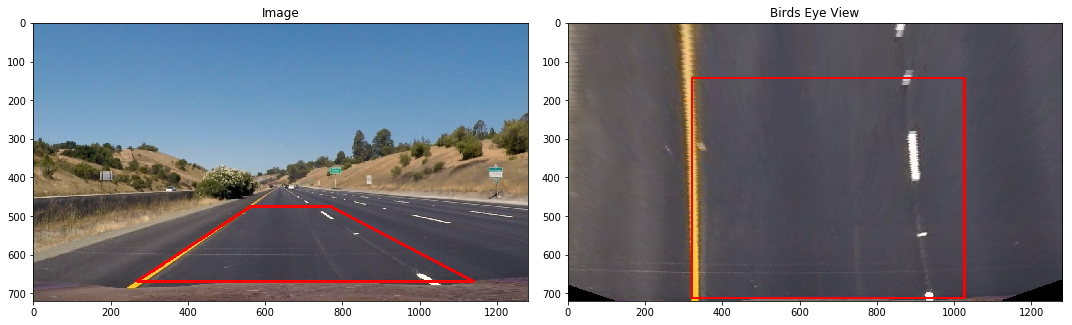

In [6]:
Minv, test_warped = perspective_transform(test_image, src, dst)

perspective_comparison(test_image,test_warped)

##Color histograph (Not Used)

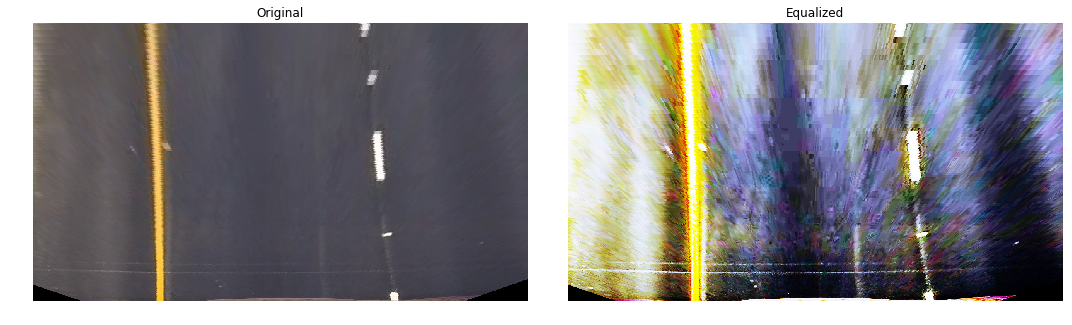

In [7]:
def histogram_equalization(image):
    r, g, b = cv2.split(image)
    red = cv2.equalizeHist(r)
    green = cv2.equalizeHist(g)
    blue = cv2.equalizeHist(b)
    return cv2.merge((red, green, blue))

def plot_histogram_comparison(img, equalized):
    # Gridspec to customize image location 
    plt.figure(figsize=(15, 10))
    gs1 = gs.GridSpec(nrows=1, ncols=2)

    ax1 = plt.subplot(gs1[0, 0])
    ax1.set_title('Original')
    plt.imshow(img)
    plt.axis('off')

    ax2 = plt.subplot(gs1[0, 1])
    ax2.set_title('Equalized')
    plt.imshow(equalized)
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    
test_equalized = histogram_equalization(test_warped)
plot_histogram_comparison(test_warped,test_equalized)

## Image Thresholding

In [8]:
def mask(img):
    # Thresholds
    yellow_lower_filter = np.array([0, 100, 100])
    yellow_upper_filter = np.array([80, 255, 255])

    white_lower_filter = np.array([200, 200, 200])
    white_upper_filter = np.array([255, 255, 255])

    # yellow masking
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    yellow_mask = cv2.inRange(hsv, yellow_lower_filter, yellow_upper_filter)
    yellow_mask = cv2.bitwise_and(img, img, mask=yellow_mask)

    # white masking
    rgb = img
    white_mask = cv2.inRange(rgb, white_lower_filter, white_upper_filter)
    white_mask = cv2.bitwise_and(img, img, mask=white_mask)

    # combined masks
    combined_mask = cv2.bitwise_or(white_mask, yellow_mask)

    # convert to binary image
    gray_mask = cv2.cvtColor(combined_mask, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray_mask)
    binary[(gray_mask > 0)] = 1
    return yellow_mask, white_mask, binary

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Applying gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create copy and apply threshold
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def final_mask(img):
    # Color masking
    y, w, color_mask = mask(img)
    # Sobel Masking
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    h = hls[:, :, 0]
    l = hls[:, :, 1]
    s = hls[:, :, 2]

    sobelx_light_mask = abs_sobel_thresh(l, orient='x', thresh=(50, 225))
    sobelx_saturation_mask = abs_sobel_thresh(s, orient='x', thresh=(50, 225))
    combined_sobel = cv2.bitwise_or(sobelx_light_mask, sobelx_saturation_mask)

    # Final Mask
    final_mask = cv2.bitwise_or(combined_sobel, color_mask)
    binary_warped = np.copy(final_mask)
    binary_warped = binary_warped[:,:]

    return binary_warped

def plot_mask_comparison(img, mask):
    # Gridspec to customize image location 
    plt.figure(figsize=(15, 10))
    gs1 = gs.GridSpec(nrows=1, ncols=2)

    ax1 = plt.subplot(gs1[0, 0])
    ax1.set_title('Original')
    plt.imshow(img)
    plt.axis('off')

    ax2 = plt.subplot(gs1[0, 1])
    ax2.set_title('Maksed')
    plt.imshow(mask,cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

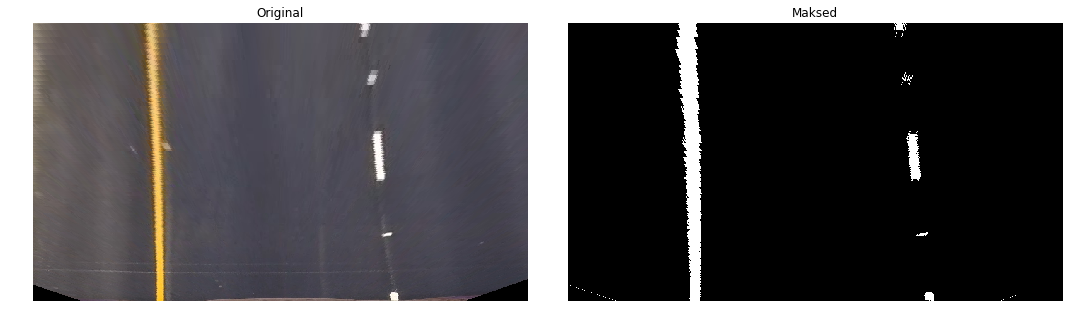

In [9]:
test_binary_warped = final_mask(test_warped)*255
cv2.imwrite('binary_image.png',test_binary_warped)
plot_mask_comparison(test_warped,test_binary_warped)
